In [ ]:
import os
import time
from collections import Counter

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    matthews_corrcoef,
    balanced_accuracy_score,
    average_precision_score,
    roc_auc_score,
)
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from google.colab import drive

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Mount Drive and Load Data

To create the training dataset, upload the `features_ring.pkl` file or `features_ring` folder, updating the path accordingly.


In [ ]:
drive.mount('/content/drive')
path = 'drive/MyDrive'

If this notebook is runned in local, change the `path`

In [2]:
path = "/Users/sebastianosanson/Development/Contacts-Classification/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label `Unclassified` to None values in the column `Interaction`

In [3]:
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


Mapping the string labels to numericals

In [4]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

y = df['Interaction'].replace(contact_dict)

/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_40737/2894892968.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


Apply a mask in order to get only the needed features to put in the dataset

In [5]:
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

Encoding the categorical features and dropping the `3di_letter` since it represent the same thing of `3di_state`

In [6]:
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

Counting the missing values in order to fill the rows with missing values by putting the mean value of the column

In [7]:
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          17807
s_psi           6736
s_3di_state    37025
t_rsa             75
t_phi           6167
t_psi          21474
t_3di_state    44036
dtype: int64

Total missing values: 133383


Filling the rows with missing values with the mean of the values of that column

In [ ]:
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

# Double-check no missing values remain
total_missing = X.isna().sum().sum()
print(f"Total missing values, after refilling: {total_missing}\n")

print(X.head())

Total missing values, after refilling: 0

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
0 -2.322  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0   
1 -1.788  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0   
2 -2.390  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0   
3 -1.088 -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0   
4 -1.551 -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0   

   s_ss8_encoded  t_ss8_encoded  
0              3              7  


This cell it is necessary for eventually engine some features and mandatory for `feature_importance` method

In [ ]:
features = ['ss8_encoded','rsa', 'phi', 'psi', 'a1', 'a2', 'a3', 'a4', 'a5', '3di_state']
feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
      't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

## Feature engineering


For each `features` are computed the following math operations:
*   Sum
*   Product
*   Absolute difference
*   Average

In [ ]:
def fe(feature):
  print(f'Engineering feature: {feature}')

  source_feature = 's_' + feature
  target_feature = 't_' + feature

  sum_feature = f'{feature}_sum'
  abs_diff_feature = f'{feature}_abs_diff'
  prod_feature = f'{feature}_prod'
  avg_feature = f'{feature}_avg'

  list_feature_names = [sum_feature, abs_diff_feature, prod_feature, avg_feature]

  X[sum_feature] = X[source_feature] + X[target_feature]
  X[abs_diff_feature] = np.abs(X[source_feature] - X[target_feature])
  X[prod_feature] = X[source_feature] * X[target_feature]
  X[avg_feature] = (X[source_feature] + X[target_feature]) / 2

  print(X.head())

  return list_feature_names

Append the new features created

In [ ]:
for feature in features:
  feature_names.extend(fe(feature))

## Splitting dataset

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.2,
    random_state=42
)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE 

Computing the inital class distribution

In [ ]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

Applying a sampling strategy in order to oversampling and computing new distribution

In [ ]:
sampling_strategy = {
    0: 675794,  # HBOND
    1: 471719,  # VDW
    2: 24501,  # PIPISTACK
    3: 22650,  # IONIC
    4: 20000,  # PICATION
    5: 10000,  # SSBOND
    6: 10000,  # PIHBOND
    7: 697310   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

print('\nResampled y_train_bal distribution')
for label in sorted(Counter(y_train)):
    print(f"{label}: {Counter(y_train)[label]}")

## XGBoost

### Helper functions

This method compute and plot the feature importance that contributes to the prediction

In [ ]:
def feature_importance(model, interaction_type, feature_names):
  # Get feature importances from the model
  importance = model.get_score(importance_type='weight')  

  # Mapping feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sorting the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance for ' + str(interaction_type) + ' interaction')
  plt.gca().invert_yaxis() 
  plt.show()

Method that evaluates the models and compute the features importance

In [ ]:
def evaluate_model(model, X_test, y_test, class_num, feature_names):
    """
    Evaluate performance of an XGBoost model.

    Parameters:
    -----------
    model_path: str
        Path to the model file
    X_test: numpy array
        Test features
    y_test: numpy array
        Test labels
    class_num: int
        Class number for binary evaluation
    """
    # Binary labels for the current class
    y_test_binary = (y_test == class_num).astype(int)
    dtest = xgb.DMatrix(X_test)

    # Get predictions from the model
    start_time = time.time()
    y_pred_prob = model.predict(dtest)
    inference_time = time.time() - start_time

    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_prob > 0.5).astype(int)

    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'AUC-ROC',
            'Matthews Correlation',
            'Average Precision',
            'Inference Time (ms)',
        ],
        'Value': [
            accuracy_score(y_test_binary, y_pred_binary),
            balanced_accuracy_score(y_test_binary, y_pred_binary),
            roc_auc_score(y_test_binary, y_pred_prob),
            matthews_corrcoef(y_test_binary, y_pred_binary),
            average_precision_score(y_test_binary, y_pred_prob),
            inference_time * 1000,
        ]
    }

    metrics_df = pd.DataFrame(metrics)

    print(f"\n===== Performance Metrics for Class {class_num} =====")
    print(metrics_df.set_index('Metric').round(4))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Other', f'Class {class_num}'],
                yticklabels=['Other', f'Class {class_num}'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Class {class_num}')
    plt.show()

    print(f"\n===== Feature Importance for Class {class_num} =====")
    feature_importance(model, class_num, feature_names)

    return metrics_df, y_pred_prob

### Train loop

Training classifier for Class 0


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.65357
[10]	validation-auc:0.69219
[20]	validation-auc:0.69690
[30]	validation-auc:0.69974
[40]	validation-auc:0.70184
[50]	validation-auc:0.70376
[60]	validation-auc:0.70557
[70]	validation-auc:0.70780
[80]	validation-auc:0.70969
[90]	validation-auc:0.71109
[100]	validation-auc:0.71249
[110]	validation-auc:0.71365
[120]	validation-auc:0.71484
[130]	validation-auc:0.71546
[140]	validation-auc:0.71604
[150]	validation-auc:0.71642
[160]	validation-auc:0.71685
[170]	validation-auc:0.71736
[180]	validation-auc:0.71765
[190]	validation-auc:0.71786
[200]	validation-auc:0.71800
[210]	validation-auc:0.71811
[220]	validation-auc:0.71816
[230]	validation-auc:0.71835
[240]	validation-auc:0.71820
[250]	validation-auc:0.71798
[260]	validation-auc:0.71794
[270]	validation-auc:0.71775
[280]	validation-auc:0.71744
[282]	validation-auc:0.71737

===== Performance Metrics for Class 0 =====
                          Value
Metric                         
Accuracy                 0.6702


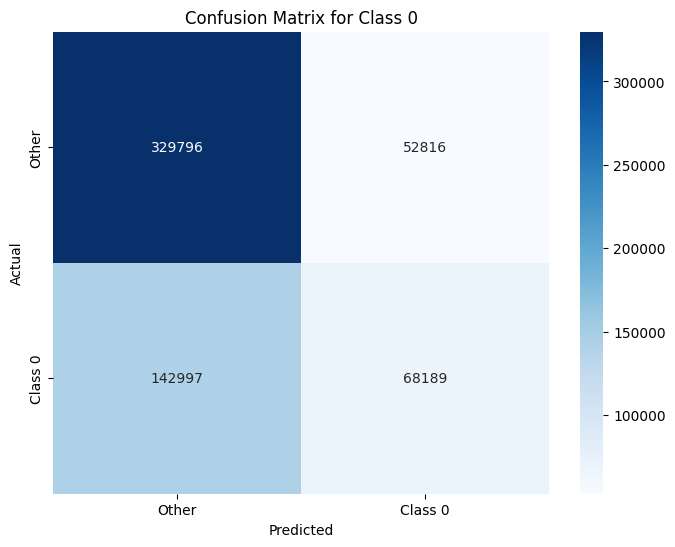


===== Feature Importance for Class 0 =====


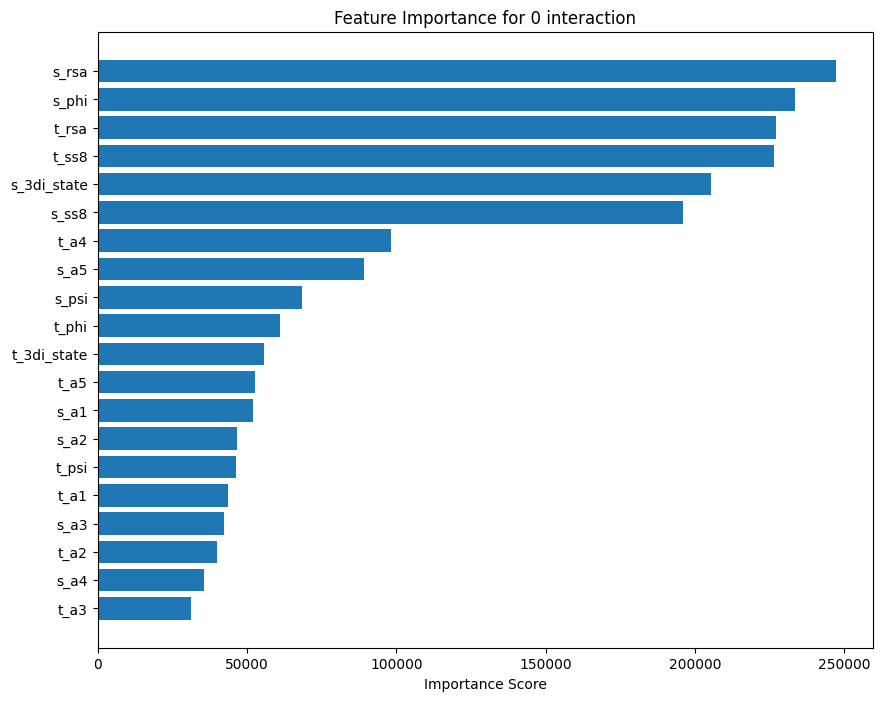

Training classifier for Class 1


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.52976
[10]	validation-auc:0.54132
[20]	validation-auc:0.54113
[30]	validation-auc:0.54003
[40]	validation-auc:0.53936
[50]	validation-auc:0.53842
[60]	validation-auc:0.53730
[63]	validation-auc:0.53704

===== Performance Metrics for Class 1 =====
                          Value
Metric                         
Accuracy                 0.7517
Balanced Accuracy        0.5001
AUC-ROC                  0.5388
Matthews Correlation     0.0079
Average Precision        0.2656
Inference Time (ms)   1188.6189


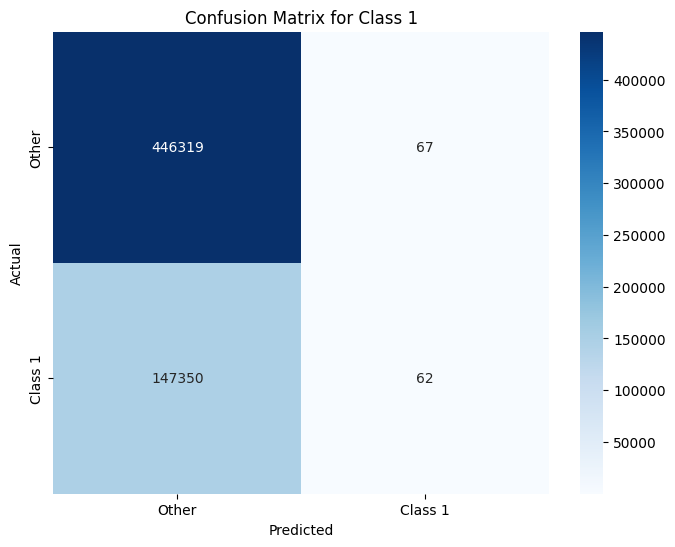


===== Feature Importance for Class 1 =====


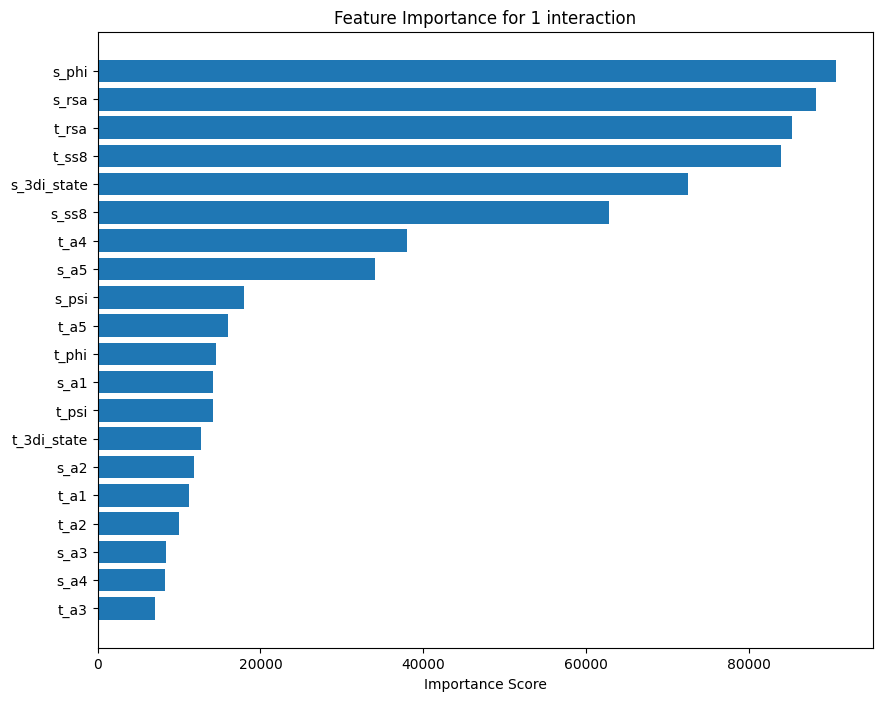

Training classifier for Class 2


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.98993
[10]	validation-auc:0.99104
[20]	validation-auc:0.99102
[30]	validation-auc:0.99097
[40]	validation-auc:0.99098
[50]	validation-auc:0.99094
[60]	validation-auc:0.99091
[62]	validation-auc:0.99091

===== Performance Metrics for Class 2 =====
                         Value
Metric                        
Accuracy                0.9871
Balanced Accuracy       0.5054
AUC-ROC                 0.9907
Matthews Correlation    0.0766
Average Precision       0.4289
Inference Time (ms)   105.7580


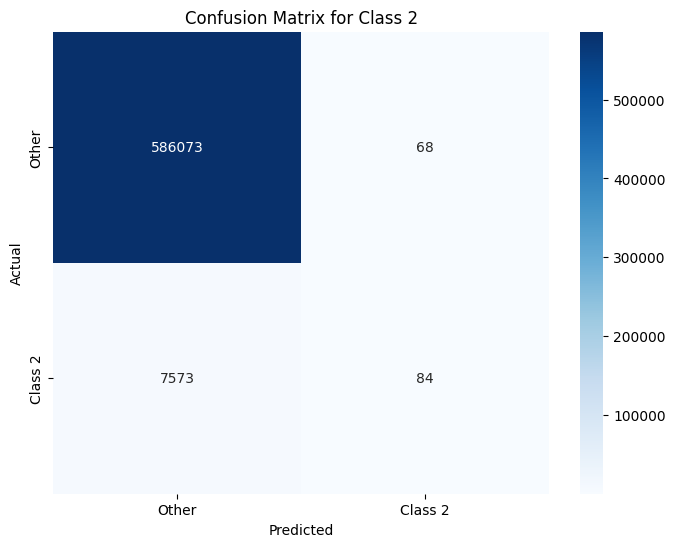


===== Feature Importance for Class 2 =====


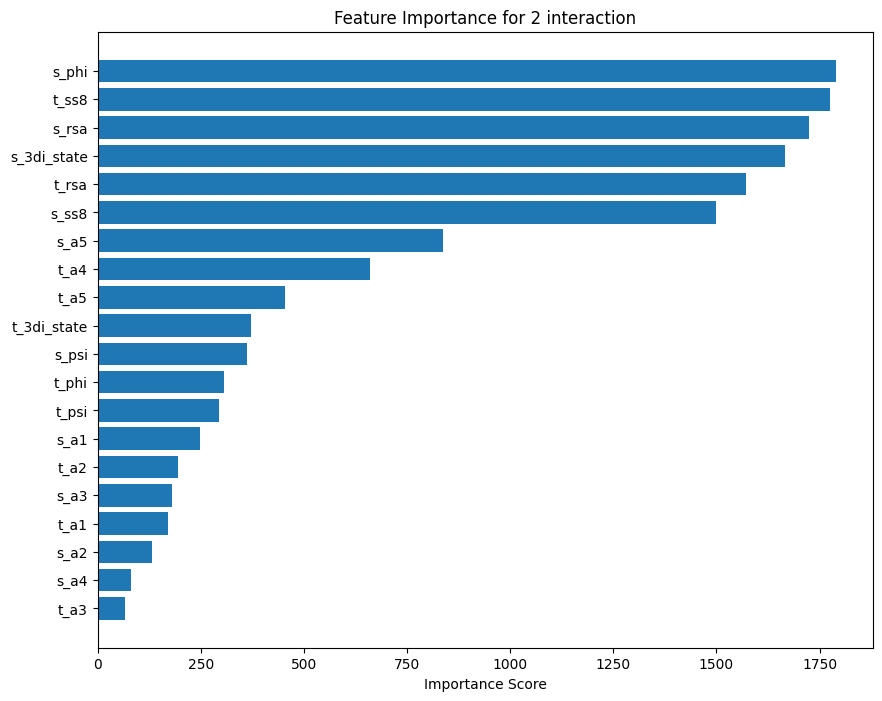

Training classifier for Class 3


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.97577
[10]	validation-auc:0.97786
[20]	validation-auc:0.97788
[30]	validation-auc:0.97784
[40]	validation-auc:0.97775
[50]	validation-auc:0.97762
[60]	validation-auc:0.97757
[68]	validation-auc:0.97754

===== Performance Metrics for Class 3 =====
                         Value
Metric                        
Accuracy                0.9881
Balanced Accuracy       0.5000
AUC-ROC                 0.9771
Matthews Correlation   -0.0002
Average Precision       0.2160
Inference Time (ms)   193.8238


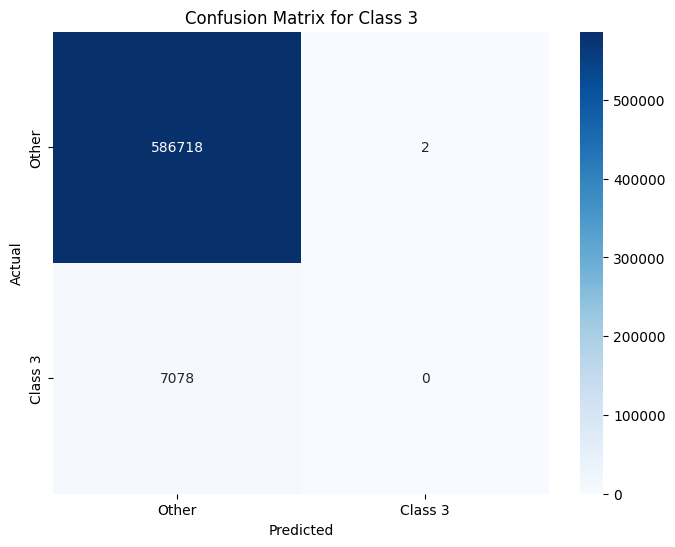


===== Feature Importance for Class 3 =====


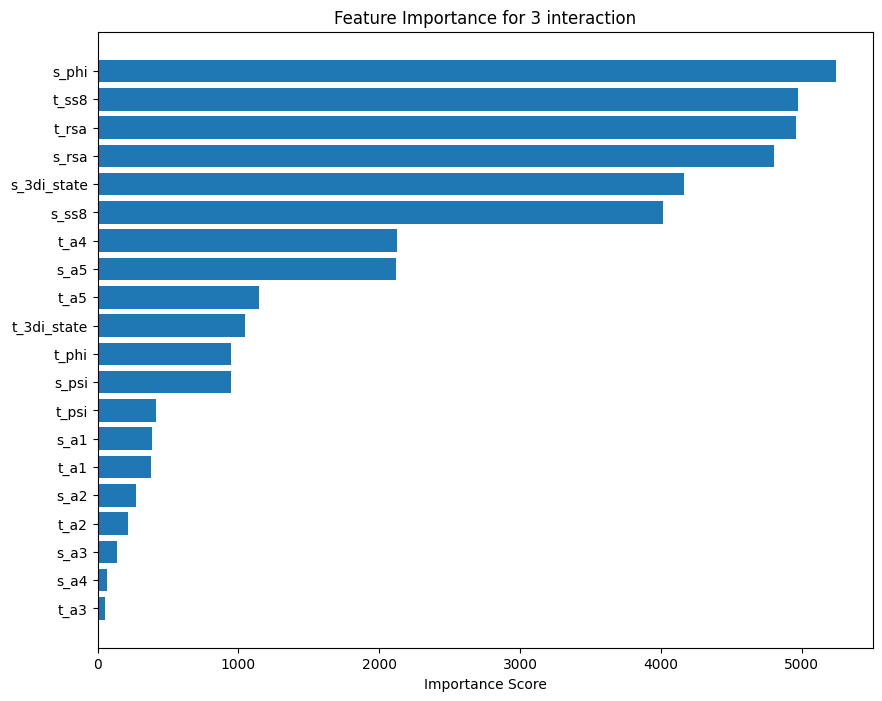

Training classifier for Class 4


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:52:11] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.98891
[10]	validation-auc:0.99118
[20]	validation-auc:0.99158
[30]	validation-auc:0.99164
[40]	validation-auc:0.99172
[50]	validation-auc:0.99179
[60]	validation-auc:0.99185
[70]	validation-auc:0.99192
[80]	validation-auc:0.99193
[90]	validation-auc:0.99197
[100]	validation-auc:0.99199
[110]	validation-auc:0.99201
[120]	validation-auc:0.99205
[130]	validation-auc:0.99206
[140]	validation-auc:0.99207
[150]	validation-auc:0.99209
[160]	validation-auc:0.99208
[170]	validation-auc:0.99206
[180]	validation-auc:0.99207
[190]	validation-auc:0.99205
[199]	validation-auc:0.99203

===== Performance Metrics for Class 4 =====
                         Value
Metric                        
Accuracy                0.9970
Balanced Accuracy       0.5039
AUC-ROC                 0.9924
Matthews Correlation    0.0443
Average Precision       0.2019
Inference Time (ms)   716.9819


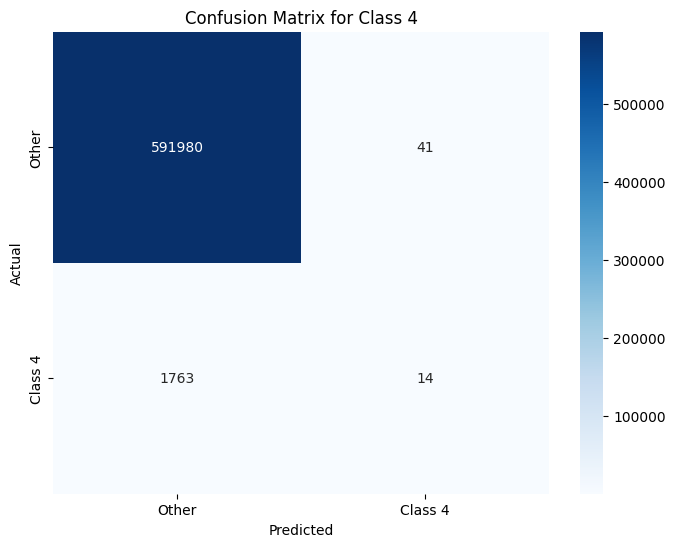


===== Feature Importance for Class 4 =====


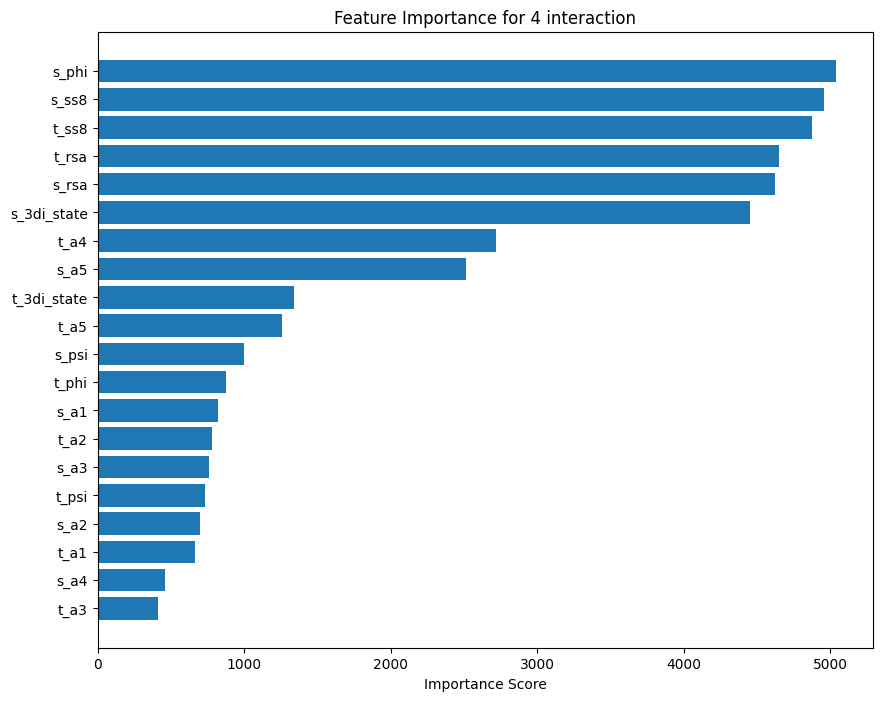

Training classifier for Class 5


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:52:29] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.99944
[10]	validation-auc:0.99955
[20]	validation-auc:0.99956
[30]	validation-auc:0.99954
[40]	validation-auc:0.99953
[50]	validation-auc:0.99952
[60]	validation-auc:0.99951
[62]	validation-auc:0.99951

===== Performance Metrics for Class 5 =====
                        Value
Metric                       
Accuracy               0.9991
Balanced Accuracy      0.7093
AUC-ROC                0.9995
Matthews Correlation   0.3887
Average Precision      0.3692
Inference Time (ms)   81.7840


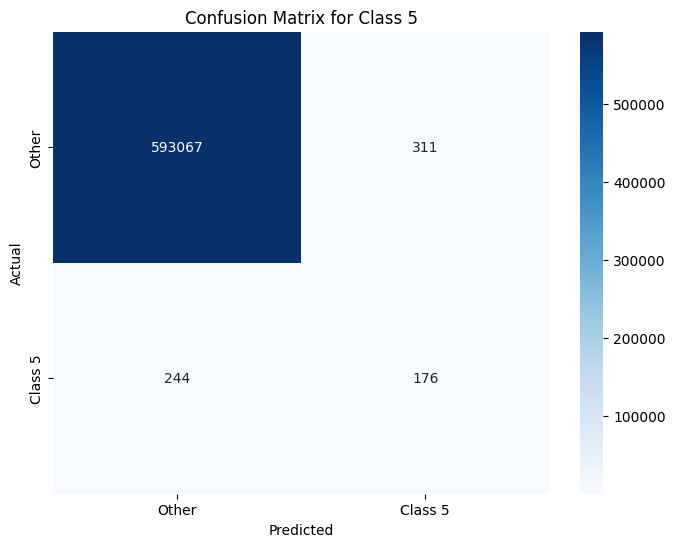


===== Feature Importance for Class 5 =====


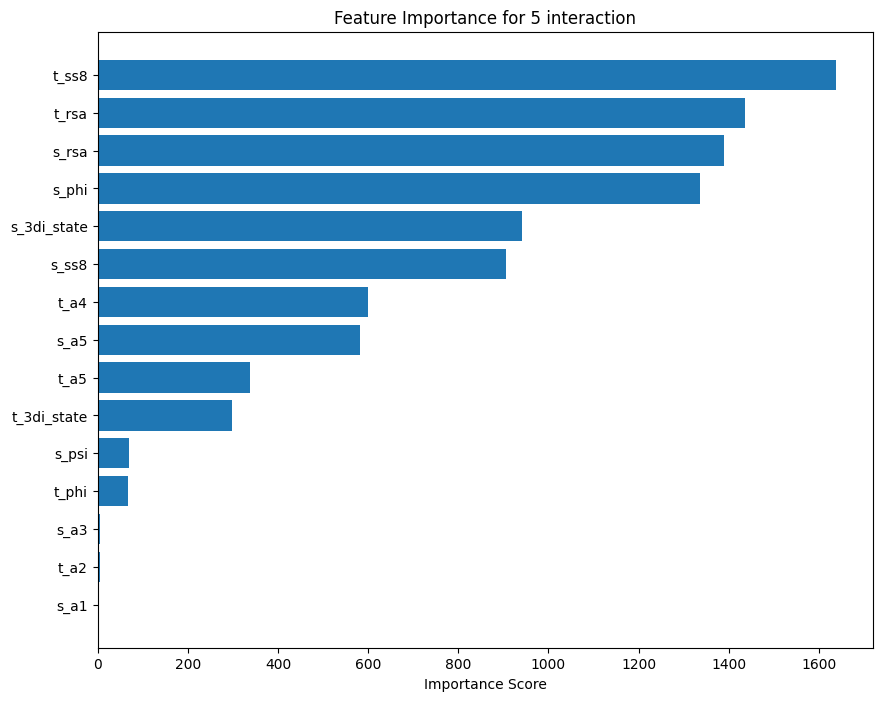

Training classifier for Class 6


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.93709
[10]	validation-auc:0.95766
[20]	validation-auc:0.96145
[30]	validation-auc:0.96336
[40]	validation-auc:0.96389
[50]	validation-auc:0.96422
[60]	validation-auc:0.96468
[70]	validation-auc:0.96562
[80]	validation-auc:0.96581
[90]	validation-auc:0.96594
[100]	validation-auc:0.96637
[110]	validation-auc:0.96669
[120]	validation-auc:0.96695
[130]	validation-auc:0.96732
[140]	validation-auc:0.96726
[150]	validation-auc:0.96737
[160]	validation-auc:0.96755
[170]	validation-auc:0.96755
[180]	validation-auc:0.96769
[190]	validation-auc:0.96769
[200]	validation-auc:0.96780
[210]	validation-auc:0.96777
[220]	validation-auc:0.96769
[230]	validation-auc:0.96743
[240]	validation-auc:0.96729
[246]	validation-auc:0.96736

===== Performance Metrics for Class 6 =====
                          Value
Metric                         
Accuracy                 0.9993
Balanced Accuracy        0.5041
AUC-ROC                  0.9745
Matthews Correlation     0.0191
Average Precision   

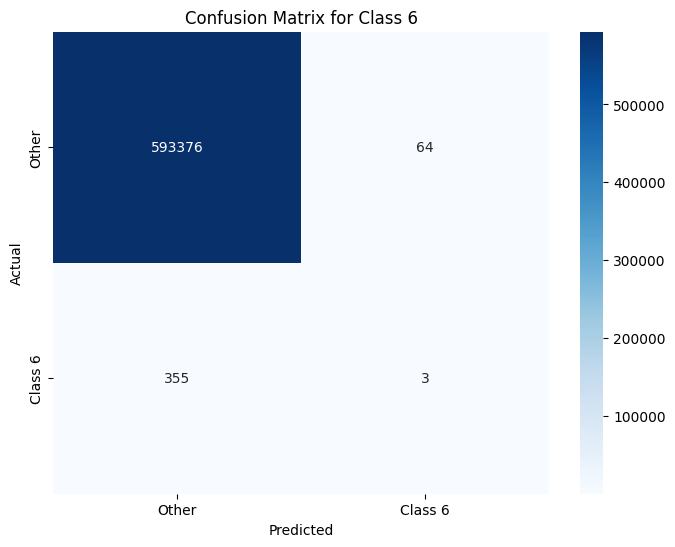


===== Feature Importance for Class 6 =====


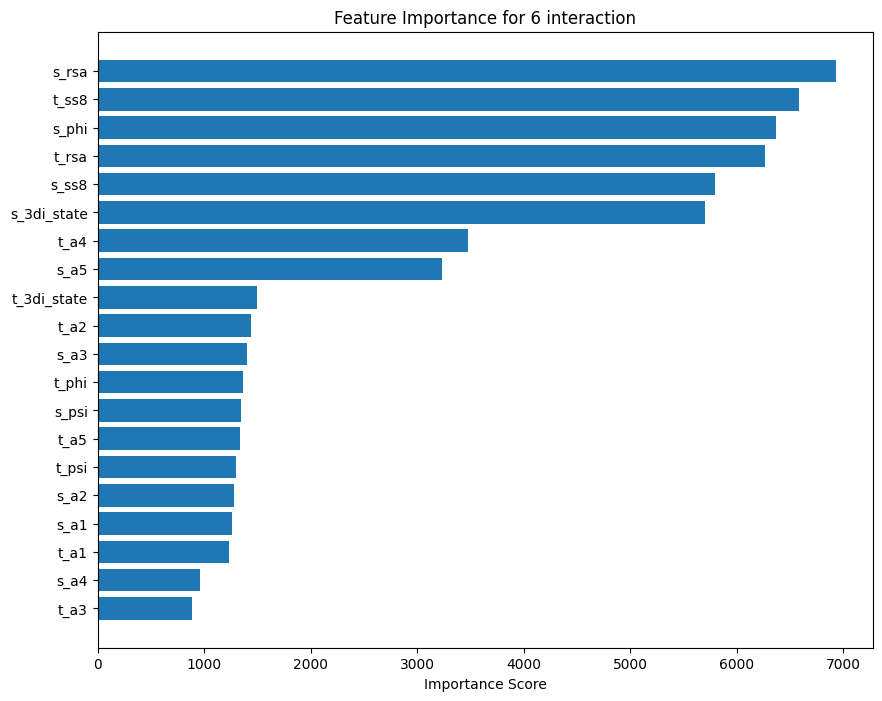

Training classifier for Class 7


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:53:09] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.68053
[10]	validation-auc:0.73164
[20]	validation-auc:0.73862
[30]	validation-auc:0.74421
[40]	validation-auc:0.74766
[50]	validation-auc:0.75110
[60]	validation-auc:0.75375
[70]	validation-auc:0.75630
[80]	validation-auc:0.75810
[90]	validation-auc:0.76039
[100]	validation-auc:0.76245
[110]	validation-auc:0.76422
[120]	validation-auc:0.76641
[130]	validation-auc:0.76846
[140]	validation-auc:0.76995
[150]	validation-auc:0.77111
[160]	validation-auc:0.77228
[170]	validation-auc:0.77318
[180]	validation-auc:0.77410
[190]	validation-auc:0.77484
[200]	validation-auc:0.77598
[210]	validation-auc:0.77666
[220]	validation-auc:0.77743
[230]	validation-auc:0.77861
[240]	validation-auc:0.77971
[250]	validation-auc:0.78081
[260]	validation-auc:0.78190
[270]	validation-auc:0.78271
[280]	validation-auc:0.78346
[290]	validation-auc:0.78435
[300]	validation-auc:0.78521
[310]	validation-auc:0.78591
[320]	validation-auc:0.78651
[330]	validation-auc:0.78711
[340]	validation-auc:0.78

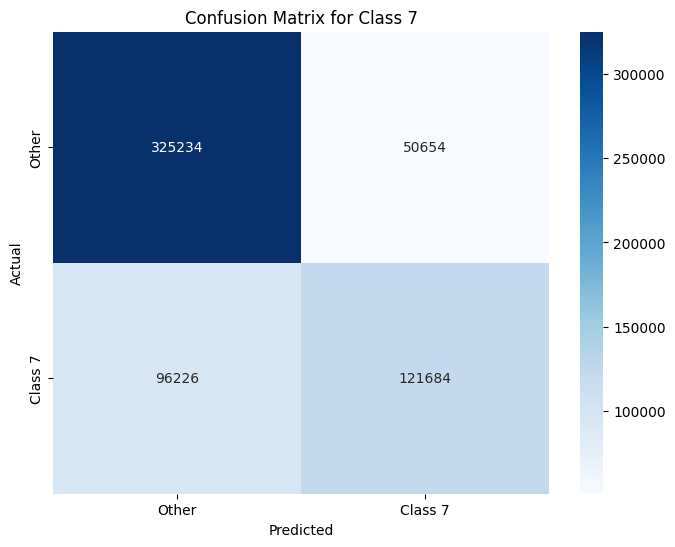


===== Feature Importance for Class 7 =====


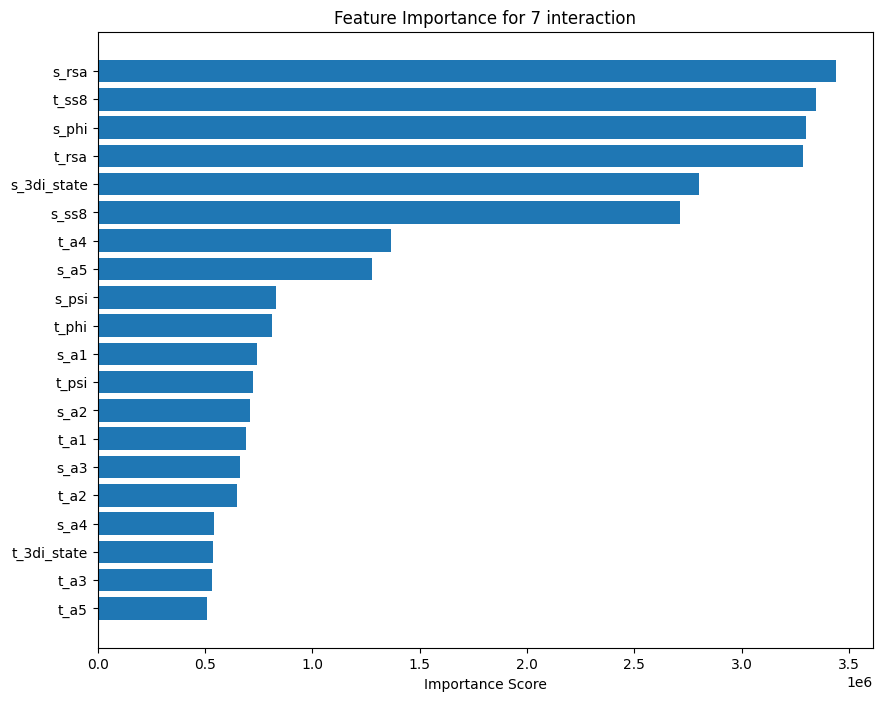

In [ ]:
# For each class, train a binary classifier
for num_class in range(len(np.unique(y_train))):
    print(f'Training classifier for Class {num_class}')

    # Mapping labels: 1 for current class, 0 for all other classes
    y_train_binary = (y_train == num_class).astype(int)
    y_val_binary = (y_val == num_class).astype(int)

    dtrain = xgb.DMatrix(X_train, label=y_train_binary)
    dval = xgb.DMatrix(X_val, label=y_val_binary)

    # Count num negative/positive examples for this class
    neg_count = np.sum(y_train_binary == 0)
    pos_count = np.sum(y_train_binary == 1)
    scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

    model = xgb.train(
        params = {
            'device': 'cuda',
            'seed': 42,
            'objective': 'binary:logistic',
            'eval_metric': 'auc',   # ['auc', 'error', 'aucpr']
            'max_depth': 15,
            'learning_rate': 0.03,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
        },
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=10
    )
    
    os.makedirs(os.path.join(path, 'models/bin_models'), exist_ok=True)
    model.save_model(os.path.join(path, f'models/bin_models/xgboost_model_class_{num_class}.json'))

    evaluate_model(model, X_test, y_test, num_class, feature_names)

## Combines models

Now all the binary classifier will be unified in order to obtain a multiclassifier

In [ ]:
from collections import defaultdict

class UnifiedXGBoostEnsemble:
    """Unified model that combines multiple binary XGBoost models"""

    def __init__(self, models_dir):
        """Load all models from the directory"""
        self.models = []
        self.models_dir = models_dir

        # Load models in order by class number
        for class_num in range(8):  # Assuming 8 classes
            model_path = os.path.join(models_dir, f"xgboost_model_class_{class_num}.json")
            if os.path.exists(model_path):
                model = xgb.Booster()
                model.load_model(model_path)
                self.models.append(model)

        self.n_classes = len(self.models)
        print(f"Successfully loaded {self.n_classes} models from {models_dir}")

    def predict_proba(self, X):
        """Get probability predictions from all models"""
        dtest = xgb.DMatrix(X)
        probas = []

        for model in self.models:
            # Get class probability from each model
            proba = model.predict(dtest)
            probas.append(proba)

        return np.column_stack(probas)

    def predict(self, X):
        """Make final predictions using max probability"""
        probas = self.predict_proba(X)
        probas_normalized = probas / np.sum(probas, axis=1, keepdims=True)

        return np.argmax(probas_normalized, axis=1)

def aggregate_feature_importance(models):
    """Aggregate feature importance scores across multiple models"""
    all_importances = defaultdict(list)
    
    # Collect importances from all models
    for model in models:
        importances = model.get_score(importance_type='weight')
        for feature, score in importances.items():
            all_importances[feature].append(score)
    
    # Compute mean importance for each feature
    mean_importances = {}
    for feature, scores in all_importances.items():
        mean_importances[feature] = sum(scores) / len(scores)
    
    return mean_importances

def evaluate_unified_ensemble(model, X_test, y_test, class_names=None):
    """
    Evaluate the unified ensemble with comprehensive metrics
    """
    if class_names is None:
        class_names = [f"Class {i}" for i in range(model.n_classes)]

    print("\n===== Evaluating Unified Ensemble (Max Probability) =====\n")

    y_pred = model.predict(X_test)
    probas = model.predict_proba(X_test)

    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'Matthews Correlation Coefficient'
        ],
        'Value': [
            accuracy_score(y_test, y_pred),
            balanced_accuracy_score(y_test, y_pred),
            matthews_corrcoef(y_test, y_pred)
        ]
    }

    # Print overall metrics
    metrics_df = pd.DataFrame(metrics)
    print("Overall Metrics:")
    print(metrics_df.set_index('Metric').round(4))

    # Calculate per-class metrics
    roc_aucs = []
    avg_precisions = []

    print("\nPer-Class Metrics:")
    for i in range(model.n_classes):
        # Binary encoding for this class
        y_true_bin = (y_test == i).astype(int)
        y_score = probas[:, i]

        roc_auc = roc_auc_score(y_true_bin, y_score)
        roc_aucs.append(roc_auc)
        avg_prec = average_precision_score(y_true_bin, y_score)
        avg_precisions.append(avg_prec)

        print(f"{class_names[i]}: ROC AUC = {roc_auc:.4f}, Avg Precision = {avg_prec:.4f}")

    print(f"\nMacro-Average ROC AUC: {np.mean(roc_aucs):.4f}")
    print(f"Macro-Average Precision: {np.mean(avg_precisions):.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Unified Ensemble')
    plt.show()

    # Compute feature importance aggregation for the unified ensemble
    feature_importance = aggregate_feature_importance(model.models)
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*feature_importance)     
    plt.figure(figsize=(10, 8))
    plt.barh(features, scores)
    plt.xlabel('Importance Score')
    plt.title('Feature Importance - Unified Ensemble')
    plt.gca().invert_yaxis()  
    plt.show()

    return {
        'accuracy': metrics['Value'][0],
        'balanced_accuracy': metrics['Value'][1],
        'matthews_corr': metrics['Value'][2],
        'roc_auc_per_class': roc_aucs,
        'avg_precision_per_class': avg_precisions,
        'predictions': y_pred,
        'probabilities': probas
    }

Unify the models and evaluation

In [16]:
models_dir = 'models/bin_models'
class_names = ["HBOND", "VDW", "PIPISTACK", "IONIC", "PICATION", "SSBOND", "PIHBOND", "Unclassified"]

unified_model = UnifiedXGBoostEnsemble(models_dir)
results = evaluate_unified_ensemble(unified_model, X_test, y_test, class_names)

: 

## Features selection

For unified model

In [ ]:
from collections import defaultdict

def feature_selection_for_unified_model(model_dir, X_train, y_train, X_test, y_test, feature_names, threshold_method='mean'):
    """
    Perform feature selection for UnifiedXGBoostEnsemble by aggregating feature importance
    from all binary models.
    
    Parameters:
    -----------
    model_dir: str
        Directory containing the binary model files
    X_train, y_train: numpy arrays
        Training data
    X_test, y_test: numpy arrays
        Test data
    feature_names: list
        Names of all features
    threshold_method: str
        Method to determine threshold ('mean', 'median', or float value)
    """
    # Load all binary models
    models = []
    for class_num in range(8):  # Assuming 8 classes
        model_path = os.path.join(model_dir, f"xgboost_model_class_{class_num}.json")
        if os.path.exists(model_path):
            model = xgb.Booster()
            model.load_model(model_path)
            models.append(model)
    
    print(f"Loaded {len(models)} binary models from {model_dir}")
    
    # Aggregate feature importance across all models
    aggregated_importance = defaultdict(float)
    
    for model in models:
        importance = model.get_score(importance_type='weight')
        for feature, score in importance.items():
            feature_idx = int(feature.replace('f', ''))
            aggregated_importance[feature_idx] += score
    
    # Convert to list of (feature_idx, importance) tuples
    importance_list = [(idx, score) for idx, score in aggregated_importance.items()]
    importance_list.sort(key=lambda x: x[1], reverse=True)
    
    # Calculate threshold 
    importance_values = np.array([score for _, score in importance_list])
    if threshold_method == 'mean':
        threshold = np.mean(importance_values)
    elif threshold_method == 'median':
        threshold = np.median(importance_values)
    elif isinstance(threshold_method, float):
        threshold = threshold_method
    else:
        threshold = np.mean(importance_values)  
    
    print(f"Feature importance threshold: {threshold:.4f}")
    
    # Select features above threshold
    selected_indices = [idx for idx, score in importance_list if score > threshold]
    
    # If no features selected, use top 10
    if not selected_indices:
        print("No features above threshold, using top 10 instead")
        selected_indices = [idx for idx, _ in importance_list[:10]]
    
    # Ensure indices are within valid range
    selected_indices = [idx for idx in selected_indices if idx < X_train.shape[1]]
    
    print(f"Selected {len(selected_indices)} features out of {X_train.shape[1]}")
    
    # Display selected feature names if available
    if feature_names:
        selected_names = [feature_names[idx] for idx in selected_indices]
        print("Selected features:")
        for idx, name in zip(selected_indices, selected_names):
            print(f"  - {name} (index: {idx})")
    
    # Plot aggregate feature importance
    plt.figure(figsize=(12, 8))
    if feature_names:
        top_features = [(feature_names[idx], score) for idx, score in importance_list[:20]]
        features, scores = zip(*top_features)
    else:
        top_features = importance_list[:20]
        features = [f"Feature {idx}" for idx, _ in top_features]
        scores = [score for _, score in top_features]
    
    plt.barh(features, scores)
    plt.xlabel('Aggregated Importance Score')
    plt.title('Top Features by Aggregated Importance')
    plt.gca().invert_yaxis()  
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Filter data to only include selected features
    X_train_selected = X_train[:, selected_indices]
    X_val_selected = X_val[:, selected_indices]
    
    new_models = []
    
    # Train new binary models with selected features
    for class_num in range(8):
        print(f"Training pruned model for Class {class_num} with selected features")
        
        # Create binary labels
        y_train_binary = (y_train == class_num).astype(int)
        y_val_binary = (y_val == class_num).astype(int)
        
        dtrain = xgb.DMatrix(X_train_selected, label=y_train_binary)
        dval = xgb.DMatrix(X_val_selected, label=y_val_binary)
        
        # Train pruned model
        pruned_model = xgb.train(
        params = {
            'device': 'cuda',
            'seed': 42,
            'objective': 'binary:logistic',
            'eval_metric': ['auc', 'error', 'aucpr'],
            'max_depth': 15,
            'learning_rate': 0.02,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'gamma': 0.2,
            'reg_alpha': 0.3,
            'reg_lambda': 1.5,
            'min_child_weight': 3
        },
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=50
    )
        
        new_models.append(pruned_model)
        
        # Save pruned model
        os.makedirs(os.path.join('models', 'unified_pruned'), exist_ok=True)
        pruned_model.save_model(os.path.join('models', 'unified_pruned', f'xgboost_model_class_{class_num}.json'))
    
    # Create and evaluate the pruned unified model
    class PrunedUnifiedXGBoostEnsemble:
        def __init__(self, models, selected_indices):
            self.models = models
            self.selected_indices = selected_indices
            self.n_classes = len(models)
            
        def predict_proba(self, X):
            # Filter features first
            X_selected = X[:, self.selected_indices]
            dtest = xgb.DMatrix(X_selected)
            probas = []
            
            for model in self.models:
                proba = model.predict(dtest)
                probas.append(proba)
            
            return np.column_stack(probas)
            
        def predict(self, X):
            probas = self.predict_proba(X)
            return np.argmax(probas, axis=1)
    
    # Create the pruned unified model
    pruned_unified_model = PrunedUnifiedXGBoostEnsemble(new_models, selected_indices)
    
    print("\nEvaluating pruned unified model...")
    
    try:
        class_names = ["HBOND", "VDW", "PIPISTACK", "IONIC", "PICATION", "SSBOND", "PIHBOND", "Unclassified"]
        _ = evaluate_unified_ensemble(pruned_unified_model, X_test, y_test, class_names)
    except:
        y_pred = pruned_unified_model.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        print(f"Pruned model accuracy: {accuracy:.4f}")
    
    return pruned_unified_model, selected_indices

In [ ]:
pruned_model, selected_features = feature_selection_for_unified_model(
    'models/bin_models', 
    X_train, y_train, 
    X_test, y_test, 
    feature_names
)